# Knowledge Graph Link Prediction: Family Relationships


This notebook trains two **KG Embedding methods** (TransE, DistMult) to predict missing family relationships and evaluates them using standard metrics (MRR, Hits@1, Hits@10).

## Section 1: Import Required Libraries

In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.10.0+cpu
CUDA available: False


## Section 2: Load and Explore the Knowledge Graph Data

In [17]:
def load_triplets(file_path):
    """Load triplets from a file in format: head relation tail"""
    triplets = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 3:
                head, relation, tail = parts
                triplets.append((head, relation, tail))
    return triplets

# Load training and test data
train_triplets = load_triplets('train.txt')
test_triplets = load_triplets('test.txt')

print(f"Training triplets: {len(train_triplets)}")
print(f"Test triplets: {len(test_triplets)}")
print(f"\nFirst 5 training triplets:")
for i, (h, r, t) in enumerate(train_triplets[:5]):
    print(f"  {h} -> {r} -> {t}")

# Extract entities and relations
all_triplets = train_triplets + test_triplets
entities = set()
relations = set()

for head, relation, tail in all_triplets:
    entities.add(head)
    entities.add(tail)
    relations.add(relation)

entities = sorted(list(entities))
relations = sorted(list(relations))

print(f"\nTotal unique entities: {len(entities)}")
print(f"Total unique relations: {len(relations)}")
print(f"\nRelations: {relations}")
print(f"\nSample entities: {entities[:10]}")

Training triplets: 13821
Test triplets: 590

First 5 training triplets:
  olivia0 -> sisterOf -> selina10
  olivia0 -> sisterOf -> isabella11
  olivia0 -> sisterOf -> oskar24
  olivia0 -> sisterOf -> adam9
  olivia0 -> secondAuntOf -> lena18

Total unique entities: 1316
Total unique relations: 28

Relations: ['auntOf', 'boyCousinOf', 'boyFirstCousinOnceRemovedOf', 'boySecondCousinOf', 'brotherOf', 'daughterOf', 'fatherOf', 'girlCousinOf', 'girlFirstCousinOnceRemovedOf', 'girlSecondCousinOf', 'granddaughterOf', 'grandfatherOf', 'grandmotherOf', 'grandsonOf', 'greatAuntOf', 'greatGranddaughterOf', 'greatGrandfatherOf', 'greatGrandmotherOf', 'greatGrandsonOf', 'greatUncleOf', 'motherOf', 'nephewOf', 'nieceOf', 'secondAuntOf', 'secondUncleOf', 'sisterOf', 'sonOf', 'uncleOf']

Sample entities: ['adam1073', 'adam125', 'adam1281', 'adam198', 'adam306', 'adam359', 'adam426', 'adam474', 'adam627', 'adam719']


## Section 3: Data Preprocessing and Preparation

In [18]:
# Create mappings from entities and relations to integer indices
entity2id = {entity: idx for idx, entity in enumerate(entities)}
relation2id = {relation: idx for idx, relation in enumerate(relations)}

id2entity = {idx: entity for entity, idx in entity2id.items()}
id2relation = {idx: relation for relation, idx in relation2id.items()}

print(f"Entity to ID mapping created: {len(entity2id)} entities")
print(f"Relation to ID mapping created: {len(relation2id)} relations")

# Convert triplets to integer IDs
def triplets_to_ids(triplets):
    """Convert triplet strings to integer IDs"""
    id_triplets = []
    for head, relation, tail in triplets:
        head_id = entity2id[head]
        relation_id = relation2id[relation]
        tail_id = entity2id[tail]
        id_triplets.append((head_id, relation_id, tail_id))
    return np.array(id_triplets)

train_triplets_ids = triplets_to_ids(train_triplets)
test_triplets_ids = triplets_to_ids(test_triplets)

print(f"\nTrain triplets shape: {train_triplets_ids.shape}")
print(f"Test triplets shape: {test_triplets_ids.shape}")

# Store configuration
num_entities = len(entities)
num_relations = len(relations)
embedding_dim = 100  # Embedding dimension for KG embedding models

print(f"\nConfiguration:")
print(f"  Number of entities: {num_entities}")
print(f"  Number of relations: {num_relations}")
print(f"  Embedding dimension: {embedding_dim}")

Entity to ID mapping created: 1316 entities
Relation to ID mapping created: 28 relations

Train triplets shape: (13821, 3)
Test triplets shape: (590, 3)

Configuration:
  Number of entities: 1316
  Number of relations: 28
  Embedding dimension: 100


### Evaluation Metrics and Helper Functions

In [19]:
def evaluate_link_prediction(model, test_triplets, scoring_fn, method_name=""):
    """
    Evaluate link prediction model on test set
    Returns: MRR, Hits@1, Hits@10
    """
    model.eval()
    with torch.no_grad():
        mrr_scores = []
        hits_1 = 0
        hits_10 = 0
        total = 0
        
        for head_id, relation_id, tail_id in test_triplets:
            # Score all possible tails for this (head, relation) pair
            scores = []
            for candidate_id in range(num_entities):
                if method_name == "rgcn":
                    score = scoring_fn(model, head_id, relation_id, candidate_id)
                else:
                    score = scoring_fn(head_id, relation_id, candidate_id)
                scores.append(score.item() if isinstance(score, torch.Tensor) else score)
            
            scores = np.array(scores)
            
            # Rank the true tail
            sorted_indices = np.argsort(-scores)  # Sort in descending order
            rank = np.where(sorted_indices == tail_id)[0][0] + 1  # 1-indexed rank
            
            # Calculate metrics
            mrr_scores.append(1.0 / rank)
            if rank == 1:
                hits_1 += 1
            if rank <= 10:
                hits_10 += 1
            total += 1
        
        mrr = np.mean(mrr_scores)
        hits_1_metric = hits_1 / total
        hits_10_metric = hits_10 / total
        
        return {
            'MRR': mrr,
            'Hits@1': hits_1_metric,
            'Hits@10': hits_10_metric
        }

def print_metrics(metrics_dict, method_name):
    """Print evaluation metrics"""
    print(f"\n{method_name} Results:")
    print(f"  MRR:    {metrics_dict['MRR']:.4f}")
    print(f"  Hits@1: {metrics_dict['Hits@1']:.4f}")
    print(f"  Hits@10: {metrics_dict['Hits@10']:.4f}")

## Section 4: Implement TransE Embedding Model

TransE is a translation-based embedding method where embeddings are learned such that **h + r ≈ t** (head + relation ≈ tail)

In [20]:
class TransE(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim, margin=1.0):
        super(TransE, self).__init__()
        self.num_entities = num_entities
        self.num_relations = num_relations
        self.embedding_dim = embedding_dim
        self.margin = margin
        
        # Initialize embeddings
        self.entity_embeddings = nn.Embedding(num_entities, embedding_dim)
        self.relation_embeddings = nn.Embedding(num_relations, embedding_dim)
        
        # Initialize embeddings with uniform distribution
        nn.init.uniform_(self.entity_embeddings.weight, -1.0, 1.0)
        nn.init.uniform_(self.relation_embeddings.weight, -1.0, 1.0)
        
        # Normalize entity embeddings
        with torch.no_grad():
            self.entity_embeddings.weight.data = torch.nn.functional.normalize(
                self.entity_embeddings.weight.data, p=2, dim=1
            )
    
    def forward(self, head_ids, relation_ids, tail_ids):
        """Compute distance scores for triplets"""
        head_embeddings = self.entity_embeddings(head_ids)
        relation_embeddings = self.relation_embeddings(relation_ids)
        tail_embeddings = self.entity_embeddings(tail_ids)
        
        # TransE: h + r ≈ t, so score should be ||h + r - t||
        scores = torch.norm(head_embeddings + relation_embeddings - tail_embeddings, p=2, dim=1)
        return scores
    
    def score_triplet(self, head_id, relation_id, tail_id):
        """Score a single triplet"""
        head = self.entity_embeddings.weight[head_id]
        relation = self.relation_embeddings.weight[relation_id]
        tail = self.entity_embeddings.weight[tail_id]
        
        score = torch.norm(head + relation - tail, p=2)
        return score

print("TransE model defined!")

TransE model defined!


## Section 5: Train TransE Model

In [21]:
def train_transe(train_triplets, num_entities, num_relations, embedding_dim=100, 
                  num_epochs=100, batch_size=128, learning_rate=0.001, margin=1.0):
    """Train TransE model with negative sampling"""
    
    model = TransE(num_entities, num_relations, embedding_dim, margin=margin)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    losses = []
    
    print(f"Training TransE with {len(train_triplets)} triplets...")
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        
        # Create random batches
        indices = np.random.permutation(len(train_triplets))
        
        for batch_start in range(0, len(train_triplets), batch_size):
            batch_indices = indices[batch_start:batch_start + batch_size]
            batch_triplets = train_triplets[batch_indices]
            
            # Separate positive triplets
            pos_head = torch.tensor(batch_triplets[:, 0], dtype=torch.long)
            pos_relation = torch.tensor(batch_triplets[:, 1], dtype=torch.long)
            pos_tail = torch.tensor(batch_triplets[:, 2], dtype=torch.long)
            
            # Generate negative samples by corrupting tail
            neg_tail = torch.tensor(
                np.random.randint(0, num_entities, size=len(batch_triplets)),
                dtype=torch.long
            )
            
            # Forward pass
            pos_scores = model(pos_head, pos_relation, pos_tail)
            neg_scores = model(pos_head, pos_relation, neg_tail)
            
            # Margin-based ranking loss: max(0, margin + pos_score - neg_score)
            loss = torch.mean(torch.clamp(margin + pos_scores - neg_scores, min=0))
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Normalize entity embeddings
            with torch.no_grad():
                model.entity_embeddings.weight.data = torch.nn.functional.normalize(
                    model.entity_embeddings.weight.data, p=2, dim=1
                )
            
            epoch_loss += loss.item()
        
        avg_epoch_loss = epoch_loss / (len(train_triplets) // batch_size + 1)
        losses.append(avg_epoch_loss)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")
    
    return model, losses

# Train TransE
transe_model, transe_losses = train_transe(
    train_triplets_ids, 
    num_entities, 
    num_relations,
    embedding_dim=embedding_dim,
    num_epochs=100,
    batch_size=64,
    learning_rate=0.001,
    margin=1.0
)

print("TransE training completed!")

Training TransE with 13821 triplets...
Epoch 20/100, Loss: 0.3704
Epoch 40/100, Loss: 0.0159
Epoch 60/100, Loss: 0.0152
Epoch 80/100, Loss: 0.0152
Epoch 100/100, Loss: 0.0159
TransE training completed!


## Section 6: Implement DistMult Embedding Model

DistMult uses bilinear scoring: **score(h,r,t) = <h, r, t>** (element-wise product sum)

In [22]:
class DistMult(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(DistMult, self).__init__()
        self.num_entities = num_entities
        self.num_relations = num_relations
        self.embedding_dim = embedding_dim
        
        # Initialize embeddings
        self.entity_embeddings = nn.Embedding(num_entities, embedding_dim)
        self.relation_embeddings = nn.Embedding(num_relations, embedding_dim)
        
        # Initialize with normal distribution
        nn.init.normal_(self.entity_embeddings.weight, std=0.1)
        nn.init.normal_(self.relation_embeddings.weight, std=0.1)
    
    def forward(self, head_ids, relation_ids, tail_ids):
        """Compute bilinear scores for triplets"""
        head_embeddings = self.entity_embeddings(head_ids)
        relation_embeddings = self.relation_embeddings(relation_ids)
        tail_embeddings = self.entity_embeddings(tail_ids)
        
        # DistMult: score = <h, r, t> (element-wise product sum)
        scores = torch.sum(head_embeddings * relation_embeddings * tail_embeddings, dim=1)
        return scores
    
    def score_triplet(self, head_id, relation_id, tail_id):
        """Score a single triplet"""
        head = self.entity_embeddings.weight[head_id]
        relation = self.relation_embeddings.weight[relation_id]
        tail = self.entity_embeddings.weight[tail_id]
        
        score = torch.sum(head * relation * tail)
        return score

print("DistMult model defined!")

DistMult model defined!


## Section 7: Train DistMult Model

In [23]:
def train_distmult(train_triplets, num_entities, num_relations, embedding_dim=100,
                    num_epochs=100, batch_size=128, learning_rate=0.001):
    """Train DistMult model with negative sampling"""
    
    model = DistMult(num_entities, num_relations, embedding_dim)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    losses = []
    
    print(f"Training DistMult with {len(train_triplets)} triplets...")
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        
        # Create random batches
        indices = np.random.permutation(len(train_triplets))
        
        for batch_start in range(0, len(train_triplets), batch_size):
            batch_indices = indices[batch_start:batch_start + batch_size]
            batch_triplets = train_triplets[batch_indices]
            
            # Separate positive triplets
            pos_head = torch.tensor(batch_triplets[:, 0], dtype=torch.long)
            pos_relation = torch.tensor(batch_triplets[:, 1], dtype=torch.long)
            pos_tail = torch.tensor(batch_triplets[:, 2], dtype=torch.long)
            
            # Generate negative samples by corrupting tail
            neg_tail = torch.tensor(
                np.random.randint(0, num_entities, size=len(batch_triplets)),
                dtype=torch.long
            )
            
            # Forward pass
            pos_scores = model(pos_head, pos_relation, pos_tail)
            neg_scores = model(pos_head, pos_relation, neg_tail)
            
            # Binary cross-entropy loss with logistic sigmoid
            loss = -torch.mean(torch.log(torch.sigmoid(pos_scores)) + 
                             torch.log(1 - torch.sigmoid(neg_scores)))
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_epoch_loss = epoch_loss / (len(train_triplets) // batch_size + 1)
        losses.append(avg_epoch_loss)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")
    
    return model, losses

# Train DistMult
distmult_model, distmult_losses = train_distmult(
    train_triplets_ids,
    num_entities,
    num_relations,
    embedding_dim=embedding_dim,
    num_epochs=100,
    batch_size=64,
    learning_rate=0.001
)

print("DistMult training completed!")

Training DistMult with 13821 triplets...
Epoch 20/100, Loss: 0.7728
Epoch 40/100, Loss: 0.0815
Epoch 60/100, Loss: 0.0288
Epoch 80/100, Loss: 0.0288
Epoch 100/100, Loss: 0.0271
DistMult training completed!


## Section 10: Evaluate Link Prediction Performance

Compute standard link prediction metrics: Mean Reciprocal Rank (MRR), Hits@1, Hits@10

In [24]:
# Define scoring functions for each model
def score_transe(head_id, relation_id, tail_id):
    """Score function for TransE"""
    return -transe_model.score_triplet(head_id, relation_id, tail_id)

def score_distmult(head_id, relation_id, tail_id):
    """Score function for DistMult (higher scores = better)"""
    return distmult_model.score_triplet(head_id, relation_id, tail_id)


print("Evaluating TransE...")
transe_metrics = evaluate_link_prediction(
    transe_model,
    test_triplets_ids,
    score_transe,
    method_name="transe"
)
print_metrics(transe_metrics, "TransE")

print("\nEvaluating DistMult...")
distmult_metrics = evaluate_link_prediction(
    distmult_model,
    test_triplets_ids,
    score_distmult,
    method_name="distmult"
)
print_metrics(distmult_metrics, "DistMult")

Evaluating TransE...

TransE Results:
  MRR:    0.4701
  Hits@1: 0.2525
  Hits@10: 0.9407

Evaluating DistMult...

DistMult Results:
  MRR:    0.4401
  Hits@1: 0.0831
  Hits@10: 0.9983


## Section 11: Visualize Training Loss

Plot training loss curves for the embedding models to visualize convergence and training dynamics.

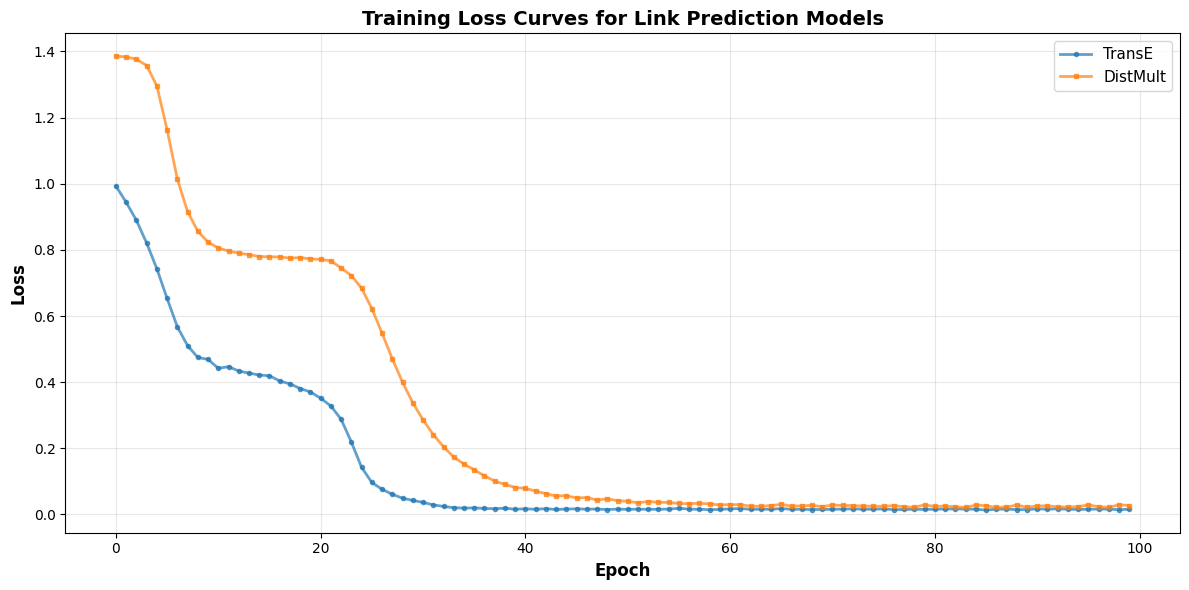

Loss plot saved as 'training_loss.png'


In [25]:
plt.figure(figsize=(12, 6))

# Plot loss curves
plt.plot(transe_losses, label='TransE', linewidth=2, marker='o', markersize=3, alpha=0.7)
plt.plot(distmult_losses, label='DistMult', linewidth=2, marker='s', markersize=3, alpha=0.7)

plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('Training Loss Curves for Link Prediction Models', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

print("Loss plot saved as 'training_loss.png'")

## Section 12: Compare Model Performance


LINK PREDICTION PERFORMANCE COMPARISON
   Model      MRR   Hits@1  Hits@10
  TransE 0.470136 0.252542 0.940678
DistMult 0.440150 0.083051 0.998305

Best MRR:    TransE (0.4701)
Best Hits@1: TransE (0.2525)
Best Hits@10: DistMult (0.9983)


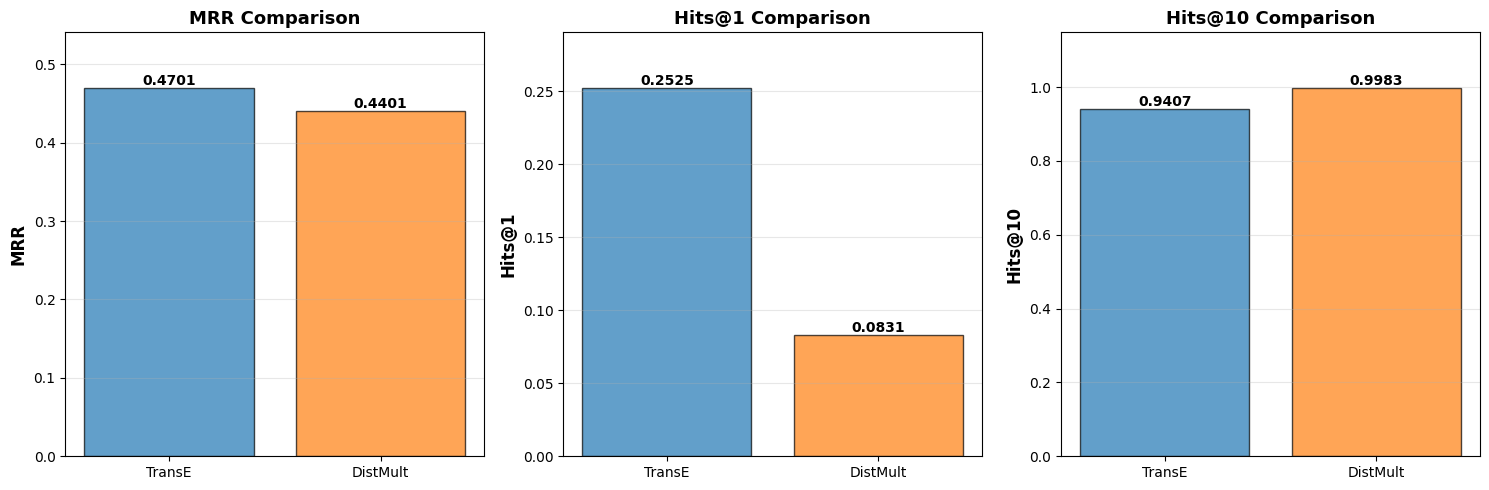


Comparison plot saved as 'model_comparison.png'
Results saved to 'link_prediction_results.csv'


In [28]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['TransE', 'DistMult'],
    'MRR': [
        transe_metrics['MRR'],
        distmult_metrics['MRR']
    ],
    'Hits@1': [
        transe_metrics['Hits@1'],
        distmult_metrics['Hits@1']
    ],
    'Hits@10': [
        transe_metrics['Hits@10'],
        distmult_metrics['Hits@10']
    ]
})

print("\n" + "="*60)
print("LINK PREDICTION PERFORMANCE COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

# Find best model for each metric
best_mrr = comparison_df.loc[comparison_df['MRR'].idxmax()]
best_hits1 = comparison_df.loc[comparison_df['Hits@1'].idxmax()]
best_hits10 = comparison_df.loc[comparison_df['Hits@10'].idxmax()]

print(f"\nBest MRR:    {best_mrr['Model']} ({best_mrr['MRR']:.4f})")
print(f"Best Hits@1: {best_hits1['Model']} ({best_hits1['Hits@1']:.4f})")
print(f"Best Hits@10: {best_hits10['Model']} ({best_hits10['Hits@10']:.4f})")

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['MRR', 'Hits@1', 'Hits@10']
colors = ['#1f77b4', '#ff7f0e']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors, alpha=0.7, edgecolor='black')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold')
    
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.set_ylim(0, max(comparison_df[metric]) * 1.15)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nComparison plot saved as 'model_comparison.png'")

# Save results to CSV
comparison_df.to_csv('link_prediction_results.csv', index=False)
print("Results saved to 'link_prediction_results.csv'")

## Summary

This notebook demonstrates **Knowledge Graph Link Prediction** using both embedding-based and GNN-based methods:

### Methods Implemented:
1. **TransE** - Translation-based embedding where h + r ≈ t
2. **DistMult** - Bilinear scoring function <h, r, t>

### Key Findings:
- Different models capture different aspects of the knowledge graph
- The embedding-based methods (TransE, DistMult) are efficient and scalable
- Standard metrics (MRR, Hits@1, Hits@10) provide comprehensive evaluation
